In [65]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import nirps_tools as nirps
import yaml

## Read input file

In [66]:
star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"stars/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        data = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise

system_info = data['star']  # Initialize as a list of one empty dictionary if no star data found
instruments = data['instruments']
ccf = data['CCF']

print('Done.')

Loading input file and data...
Done.


## Load data

In [67]:
tbl = {}
tbl_ccf = {}
rv_off = {}
rv_off_ccf = {}
tlabel = "t"

# Name of files
files = {}

# Adjust the file labels
Dtemp_suf = []

# # Get the CCF data if it exists
for instrument in ccf:
    tbl_ccf[instrument] = {}
    if ccf[instrument]['DRS-3-0-0']: 
        tbl_ccf[instrument]['DRS-3-0-0'] = Table.read(f'stars/{star}/data/{star}_{instrument}_DRS-3-0-0.rdb', format='rdb')
        tbl_ccf[instrument]['DRS-3-0-0'][tlabel] = tbl_ccf[instrument]['DRS-3-0-0']["rjd"] #- extra_off

    if ccf[instrument]['DRS-3-5']:
        tbl_ccf[instrument]['DRS-3-5'] = Table.read(f'stars/{star}/data/{star}_{instrument}_DRS-3-5.rdb', format='rdb')
        tbl_ccf[instrument]['DRS-3-5'][tlabel] = tbl_ccf[instrument]['DRS-3-5']["rjd"] #- extra_off
    

i = 0
for instrument in instruments:
    star_name = system_info.get('name', '')  # Accessing the first element of the star_info list
    ref_star = instruments[instrument].get('ref_star', '')
    suffix = instruments[instrument].get('dtemp_suffix', '')
    bin_label = instruments[instrument].get('bin_label', '')
    pca_label = instruments[instrument].get('pca_label', '')
    Dtemp_suf.append(instruments[instrument].get('dtemp_suffix', ''))
    
    files[instrument] = f'stars/{star}/data/lbl{bin_label}_{instrument}_{star}_{ref_star}{pca_label}'
    
    tbl[instrument] = Table.read(files[instrument]+'.rdb', format='rdb')
    
    # Remove NaNs 
    tbl[instrument] = nirps.remove_nans_from_table(tbl[instrument])

    if ccf[instrument]['DRS-3-0-0']:
        rv_off_ccf[instrument] = np.median(tbl_ccf[instrument]['DRS-3-0-0']["vrad"])
        tbl_ccf[instrument]['DRS-3-0-0']["vrad"] -= rv_off_ccf[instrument]

    #rjd_bjd_off = 2457000
    #extra_off_factor = 100
    #extra_off = np.floor(tbl[instrument]["rjd"].min() / extra_off_factor) * extra_off_factor
    #t_off = rjd_bjd_off + extra_off


    tbl[instrument][tlabel] = tbl[instrument]["rjd"] #- extra_off
    i+=1

## Checking wavelength bins

### Store wave bins of different instruments here

In [68]:
wave_bins = {}

wave_bins['HARPS'] = [407, 423, 439, 455, 473, 491, 509, 529, 549, 570, 591, 614, 637, 662, 687]
wave_bins['NIRPS'] = [914, 942, 972, 1003, 1034, 1067, 1100, 1135, 1170, 1207, 1245, 1284, 1324,
                      1366, 1409, 1453, 1499, 1546, 1595, 1645, 1696, 1750, 1805, 1861, 1920]

In [69]:
good_waves = {}
rv_offset = {}

for instrument in instruments:
    good_waves[instrument] = []
    
    for wave in wave_bins[instrument]:
        rv_offset[instrument] = np.mean(tbl[instrument]['vrad'])
        
        if np.abs(np.mean(tbl[instrument][f'vrad_{wave}nm']) - rv_offset[instrument]) > 1000:
            continue
        
        good_waves[instrument].append(wave)


NIRPS


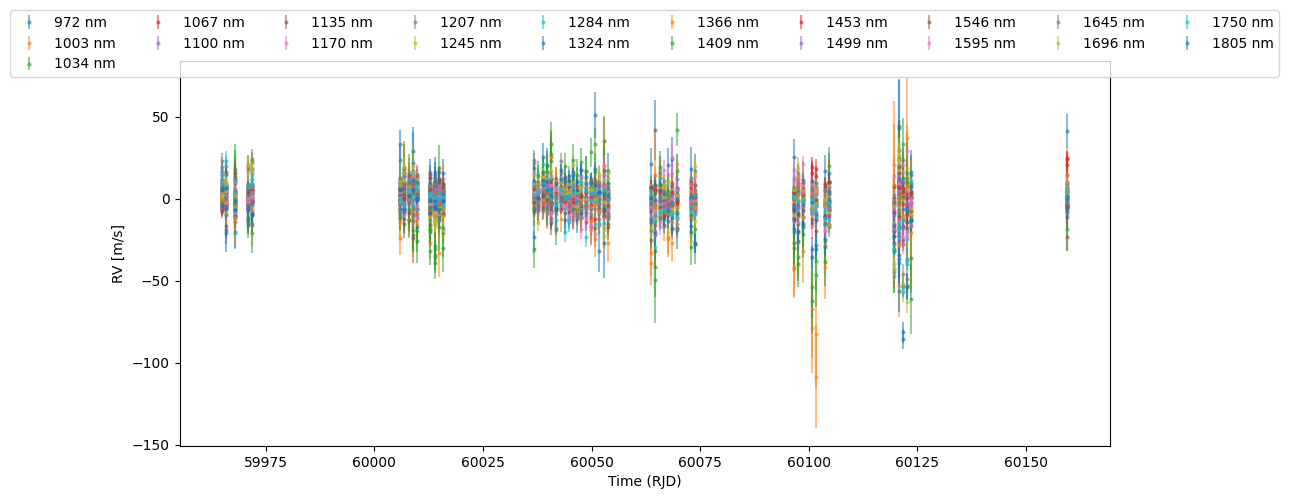

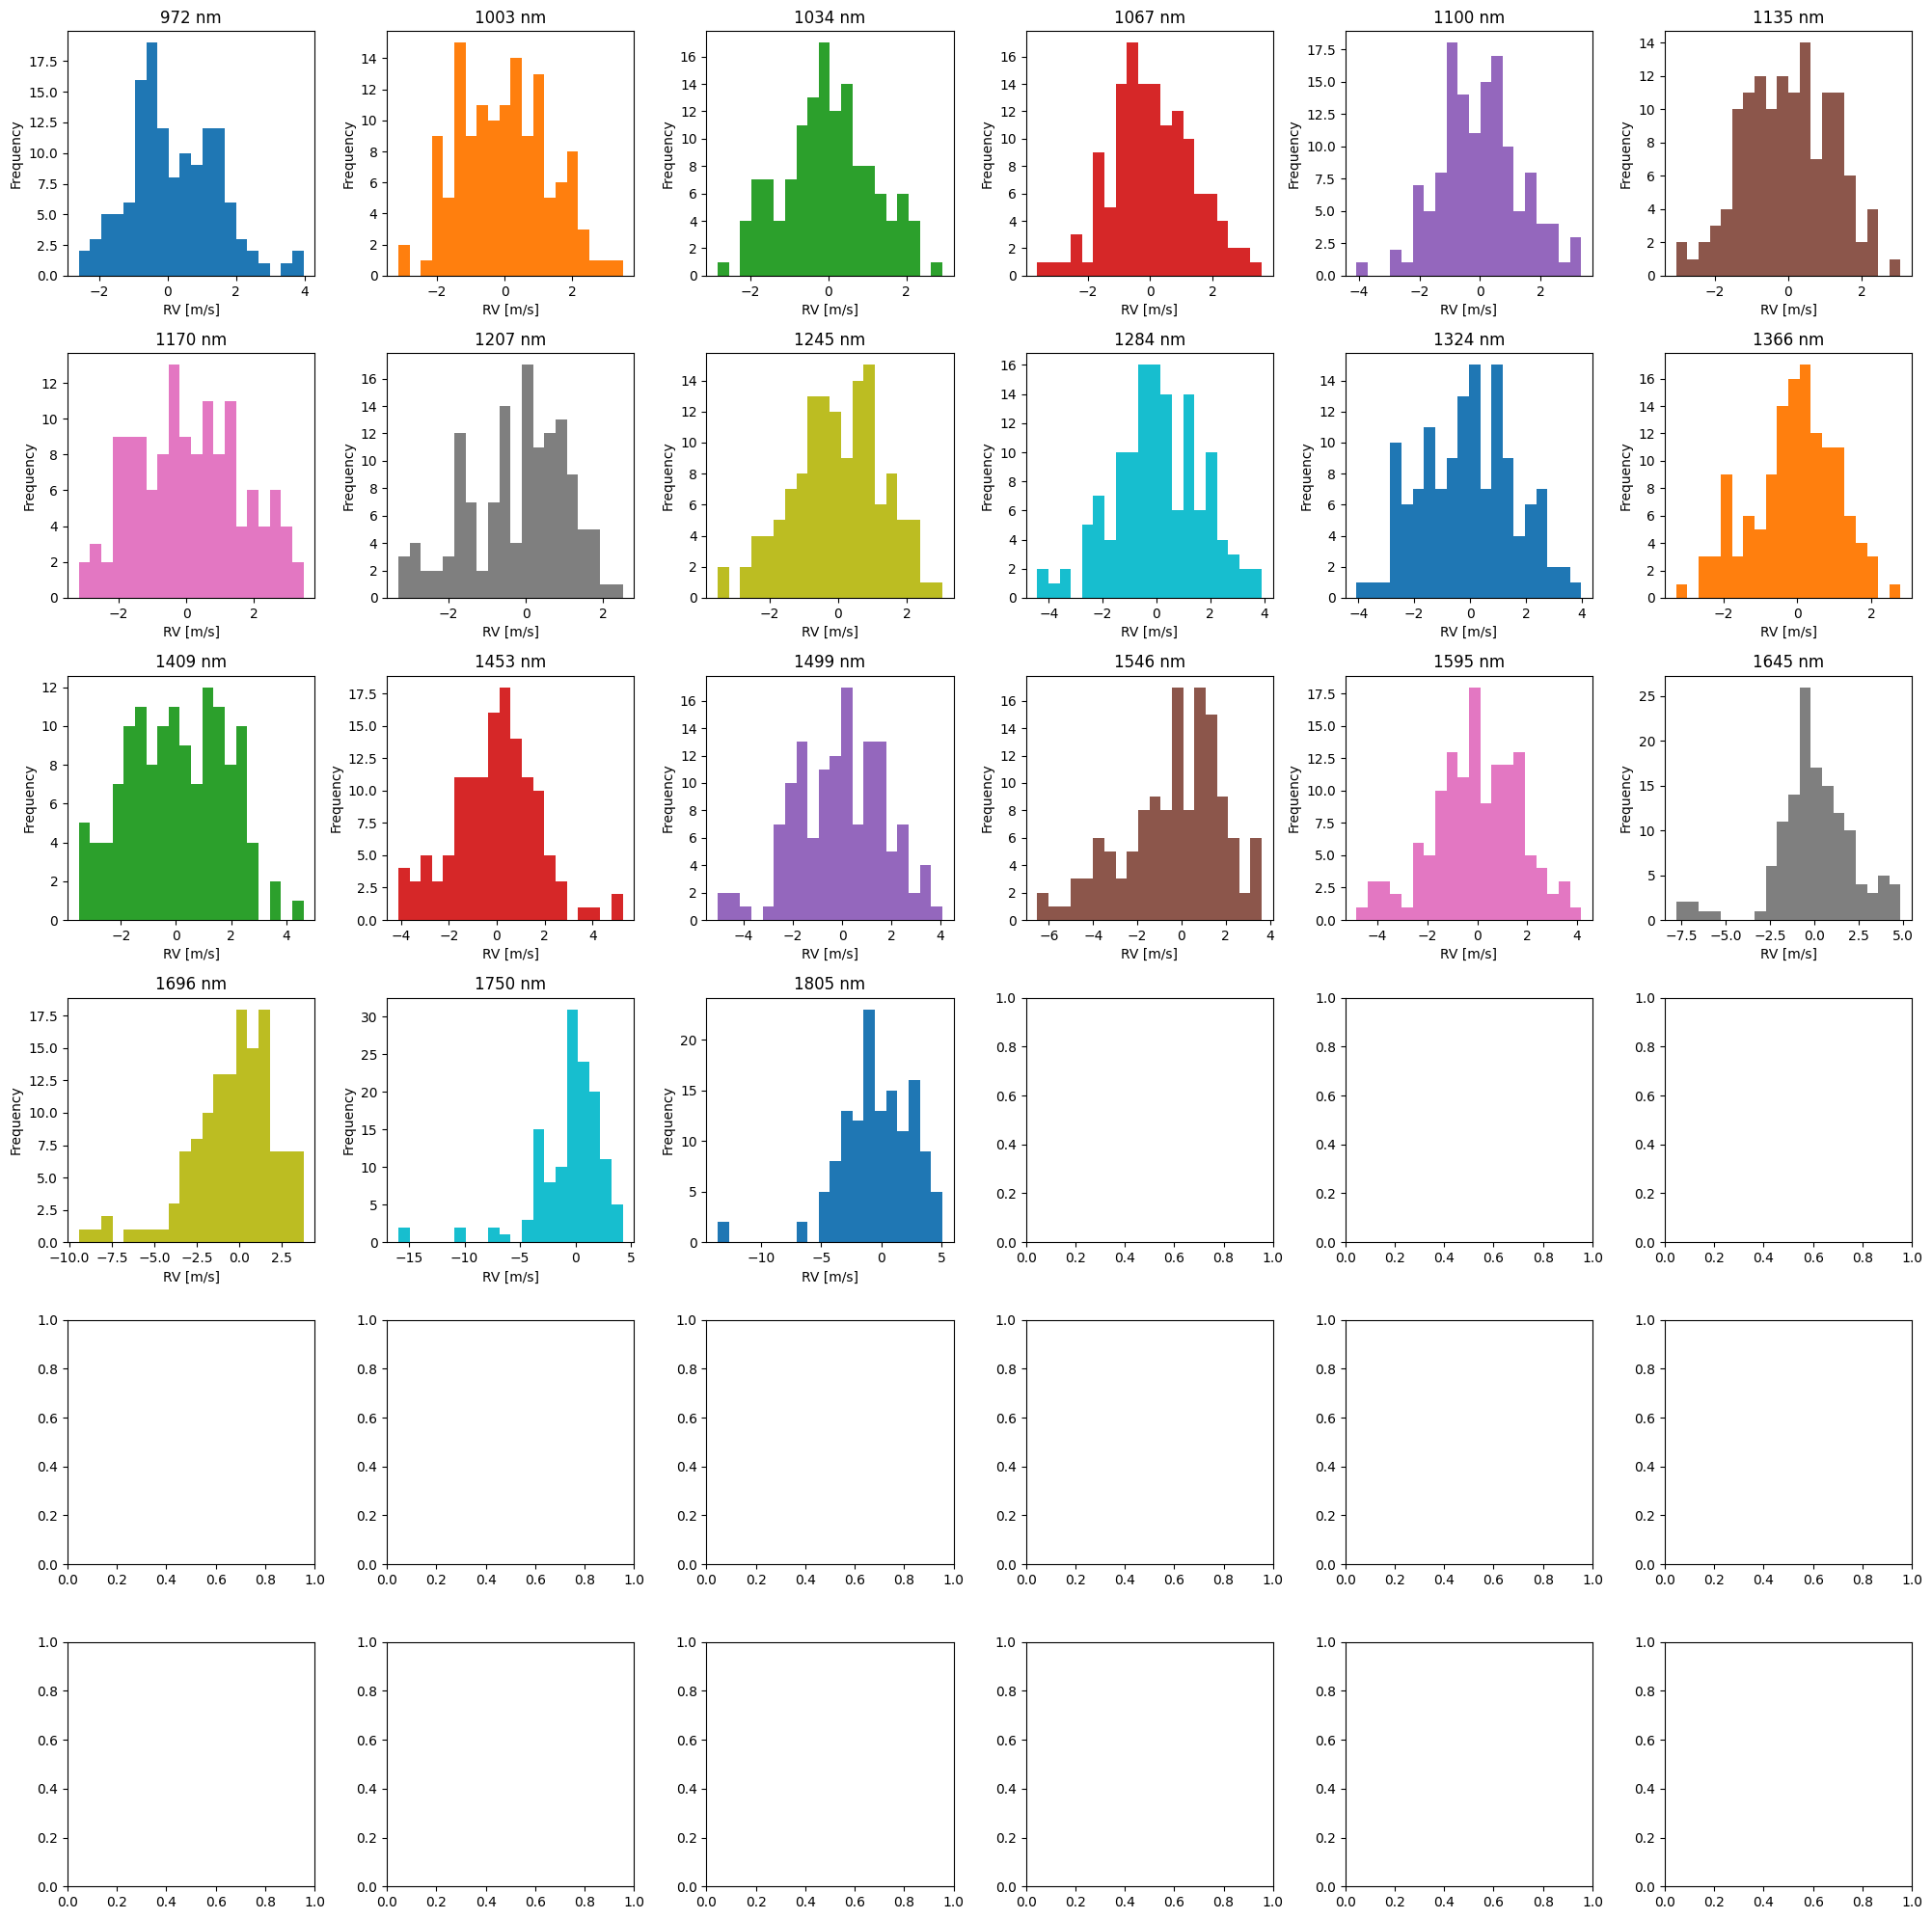

HARPS


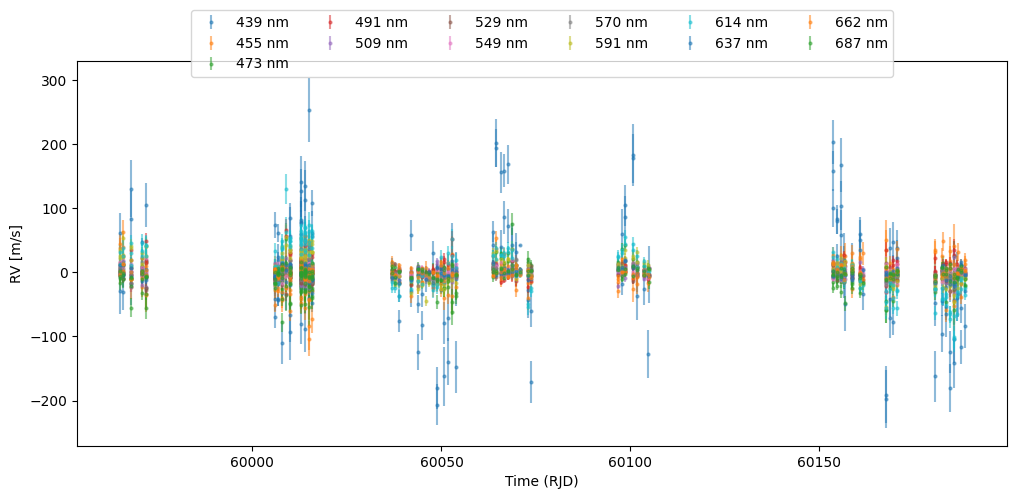

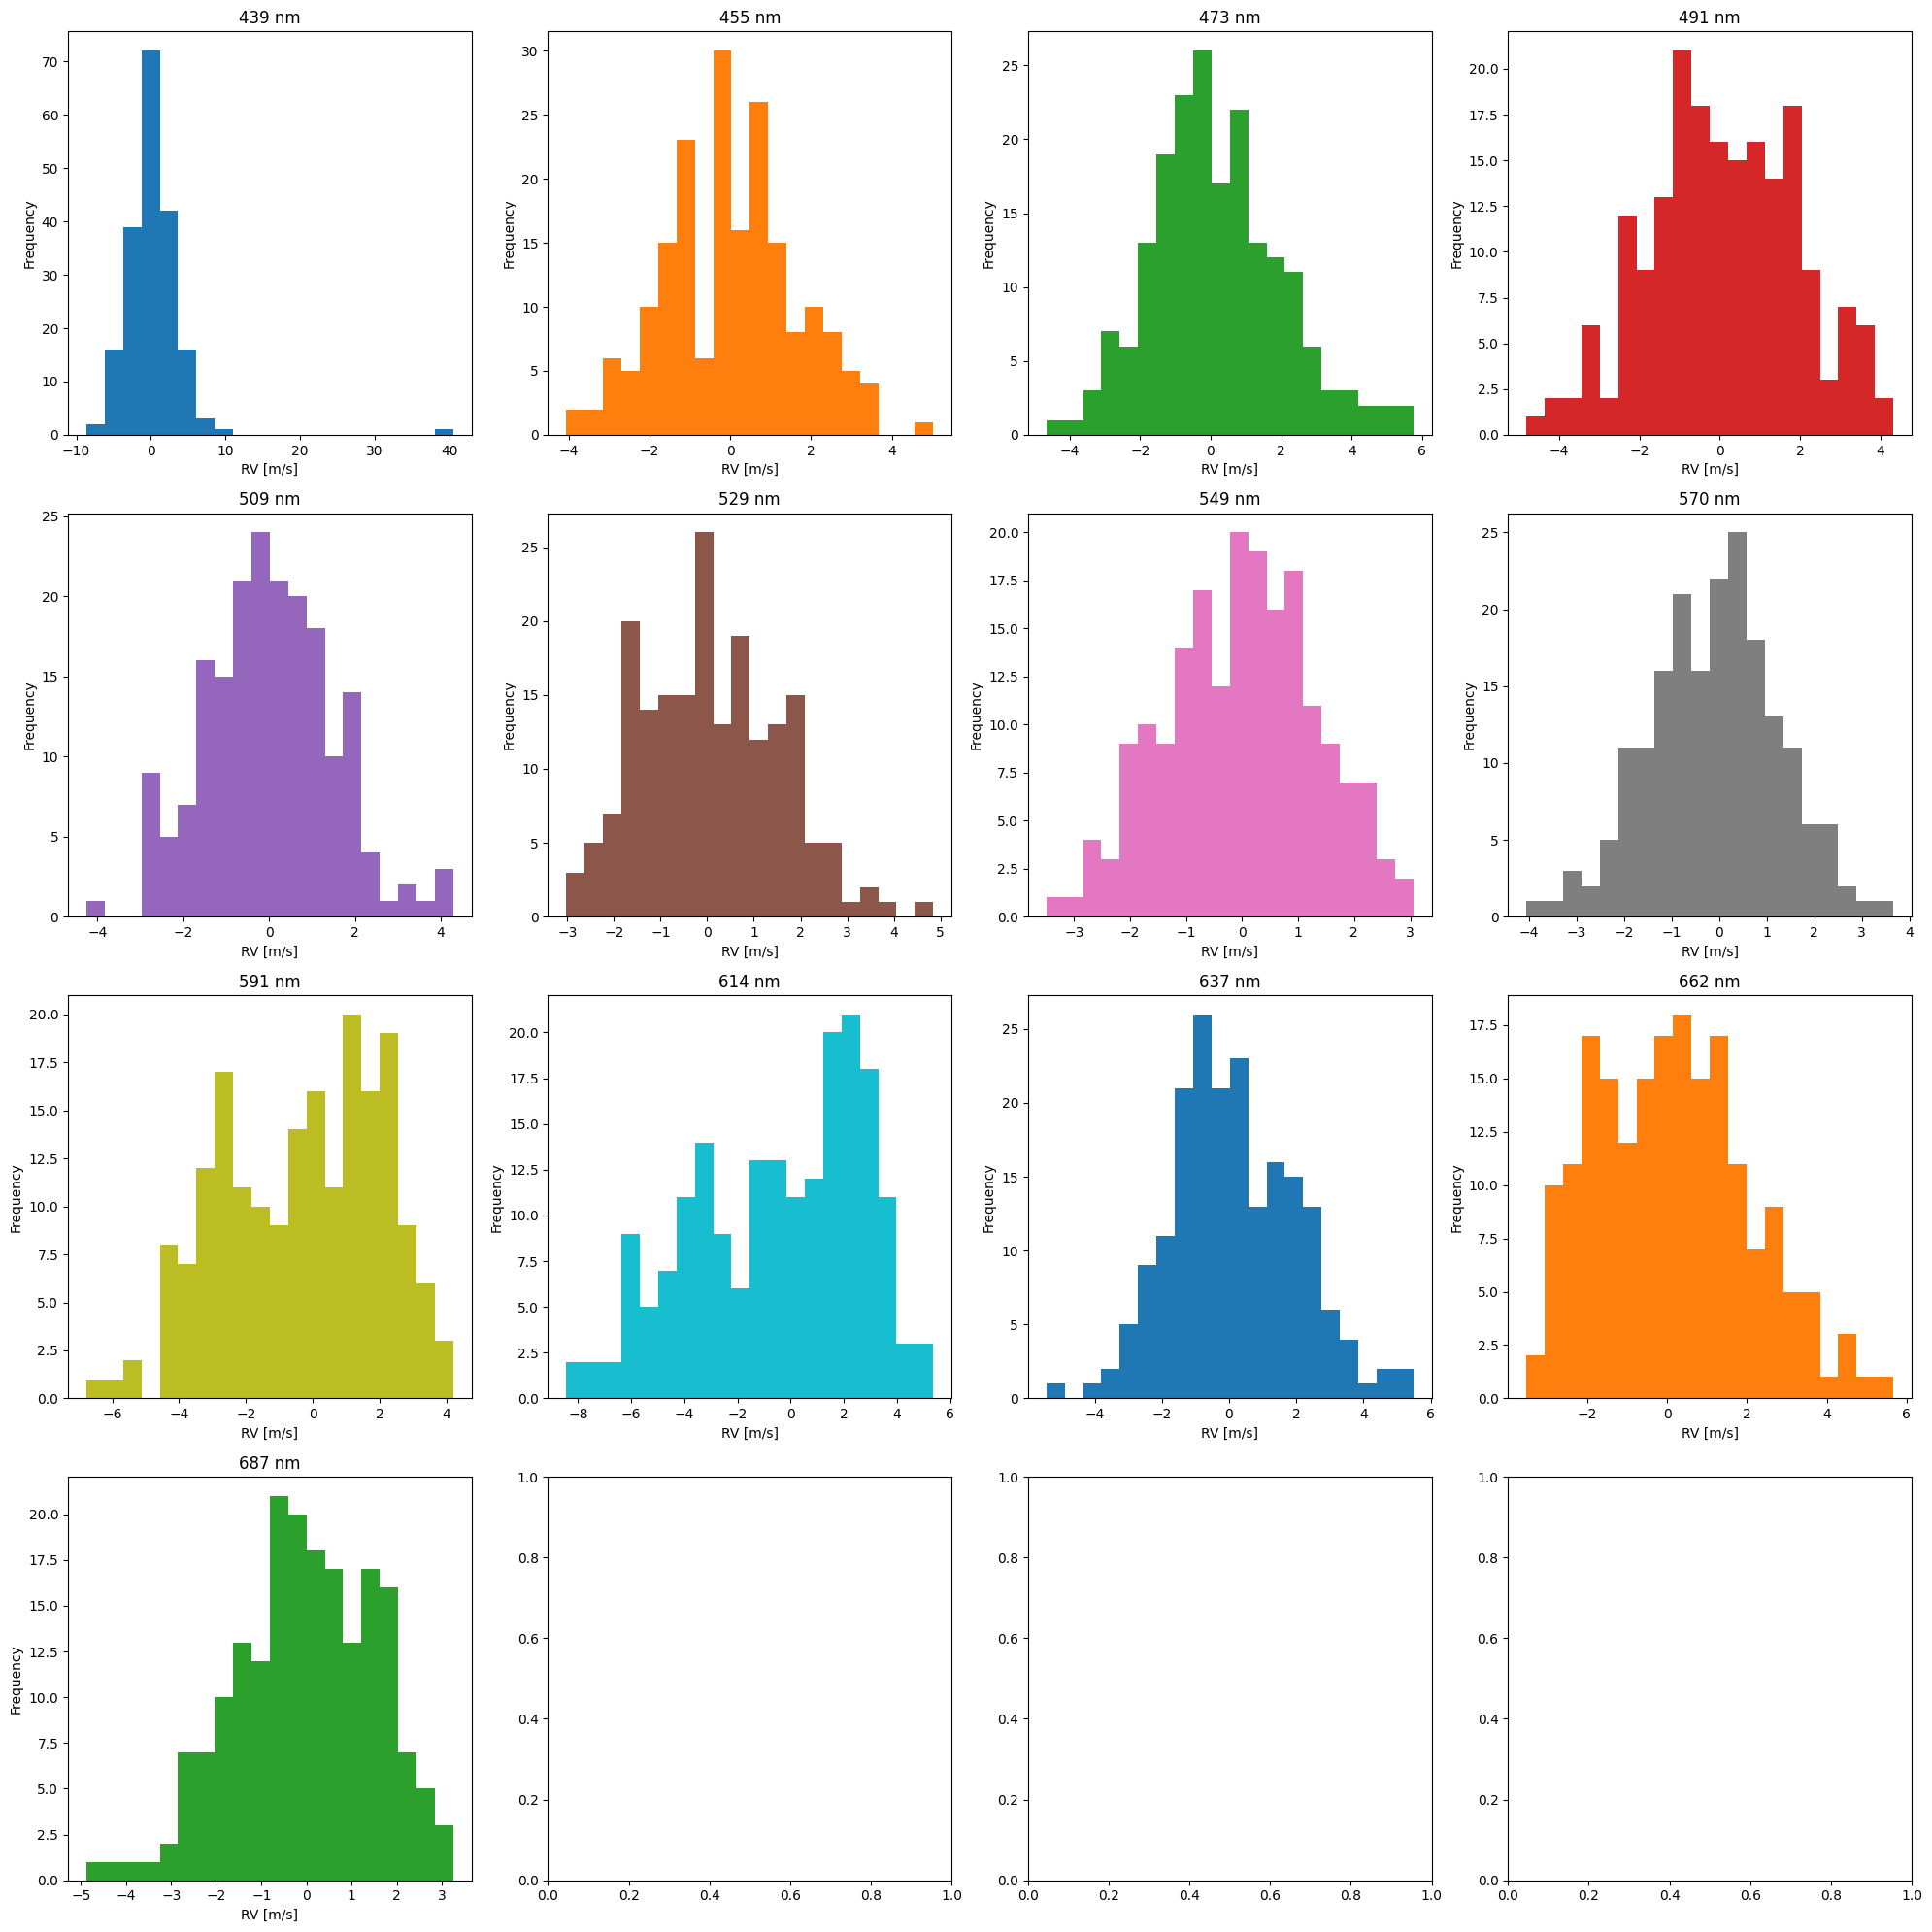

In [70]:
norm_err = {}
y_rv = {}
yerr_rv = {}

for instrument in instruments: 
    print(f'{instrument}')

    rv_offset[instrument] = np.mean(tbl[instrument]['vrad'])
    
    fig = plt.figure(figsize=(12, 5))
    y_rv[instrument] = {}
    yerr_rv[instrument] = {}
                    
    for i, wave in enumerate(good_waves[instrument]):
        
        y_rv[instrument][f'vrad_{wave}nm'] = tbl[instrument][f'vrad_{wave}nm'] - rv_offset[instrument]
        yerr_rv[instrument][f'svrad_{wave}nm'] = tbl[instrument][f'svrad_{wave}nm']
        
        
        plt.errorbar(tbl[instrument]['rjd'], y_rv[instrument][f'vrad_{wave}nm'], yerr=yerr_rv[instrument][f'svrad_{wave}nm'], fmt='o', markersize=2,
                    label=f'{wave} nm', alpha=0.5, color = f'C{i}')
        plt.xlabel('Time (RJD)')
        plt.ylabel('RV [m/s]')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(good_waves[instrument])/2)
    plt.show()
    
    # Create a new figure with subplots
    sqrt_N_display = int(np.sqrt(len(wave_bins[instrument])))+1

    fig, axs = plt.subplots(sqrt_N_display, sqrt_N_display, figsize=(20, 20))

    # Plot histograms for each wavelength
    for i, wave in enumerate(good_waves[instrument]):
        row = i // sqrt_N_display
        col = i %  sqrt_N_display
        
        norm_err[f'vrad_{wave}nm'] = (y_rv[instrument][f'vrad_{wave}nm'] - np.nanmedian(y_rv[instrument][f'vrad_{wave}nm']))/yerr_rv[instrument][f'svrad_{wave}nm']
            
        axs[row, col].hist(norm_err[f'vrad_{wave}nm'], color = f'C{i}', bins=20)
        axs[row, col].set_xlabel('RV [m/s]')
        axs[row, col].set_ylabel('Frequency')
        axs[row, col].set_title(f'{wave} nm')

    plt.tight_layout()
    plt.show()
        


Manually remove bad wavelengths

In [71]:
good_waves['HARPS'].remove(439)

In [72]:
good_waves

{'NIRPS': [972,
  1003,
  1034,
  1067,
  1100,
  1135,
  1170,
  1207,
  1245,
  1284,
  1324,
  1366,
  1409,
  1453,
  1499,
  1546,
  1595,
  1645,
  1696,
  1750,
  1805],
 'HARPS': [455, 473, 491, 509, 529, 549, 570, 591, 614, 637, 662, 687]}

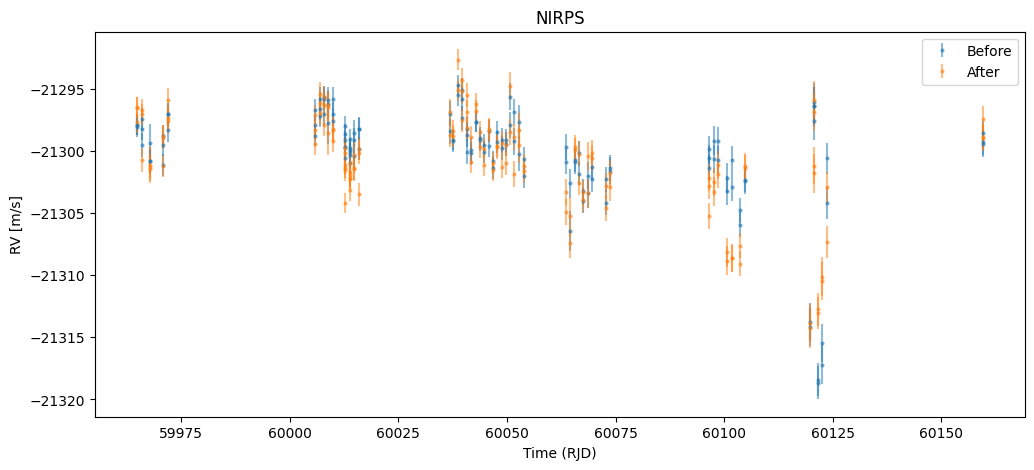

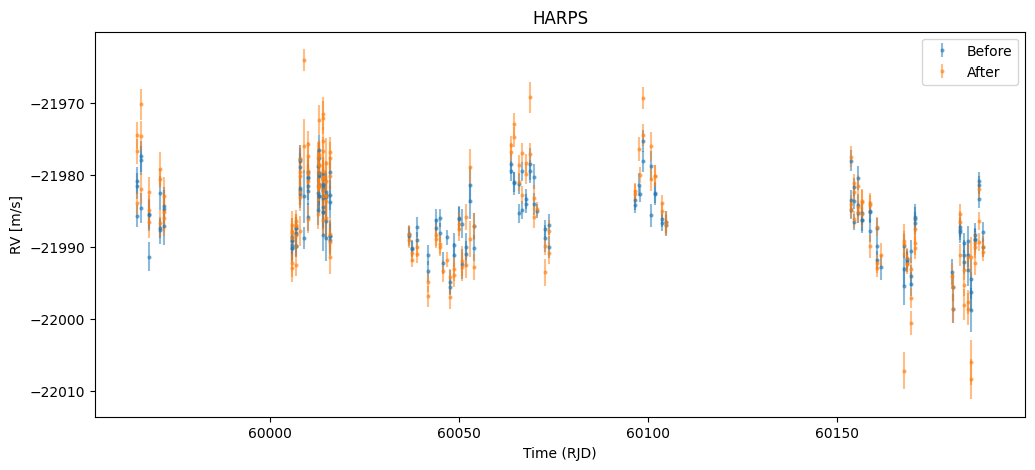

In [73]:
# Create a new dictionary to store the mean of all good wavelengths
new_vrad = {}
#new_svrad = {}

# Calculate the mean of all good wavelengths for each instrument
for instrument in instruments:
    new_vrad[instrument] = np.mean([tbl[instrument][f'vrad_{wave}nm'] for wave in good_waves[instrument]], axis=0)
    #new_svrad[instrument] = np.mean([tbl[instrument][f'svrad_{wave}nm'] for wave in good_waves[instrument]], axis=0)
    
    # Plot the new RVs
    fig = plt.figure(figsize=(12, 5))
    plt.errorbar(tbl[instrument]['rjd'], tbl[instrument]['vrad'], yerr=tbl[instrument]['svrad'], fmt='o', markersize=2,
                label='Before', alpha=0.5)
    
    
    tbl[instrument]['vrad'] = new_vrad[instrument]
    #tbl[instrument]['svrad'] = new_svrad[instrument]

    # Write the new table to an .rdb file
    tbl[instrument].write(f'stars/{star}/data/lbl{bin_label}_{instrument}_{star}_{ref_star}{pca_label}_cleaned.rdb', format='rdb', overwrite = True)
    
    plt.errorbar(tbl[instrument]['rjd'], tbl[instrument]['vrad'], yerr=tbl[instrument]['svrad'], fmt='o', markersize=2,
                label='After', alpha=0.5)
    plt.xlabel('Time (RJD)')
    plt.ylabel('RV [m/s]')
    plt.title(f'{instrument}')
    plt.legend()
    plt.show()


To-do: 
- Plot histograms of the dispersion of RVs for a single observation in all wavelengths
- Save a file of the uncorrupted wavelengths 

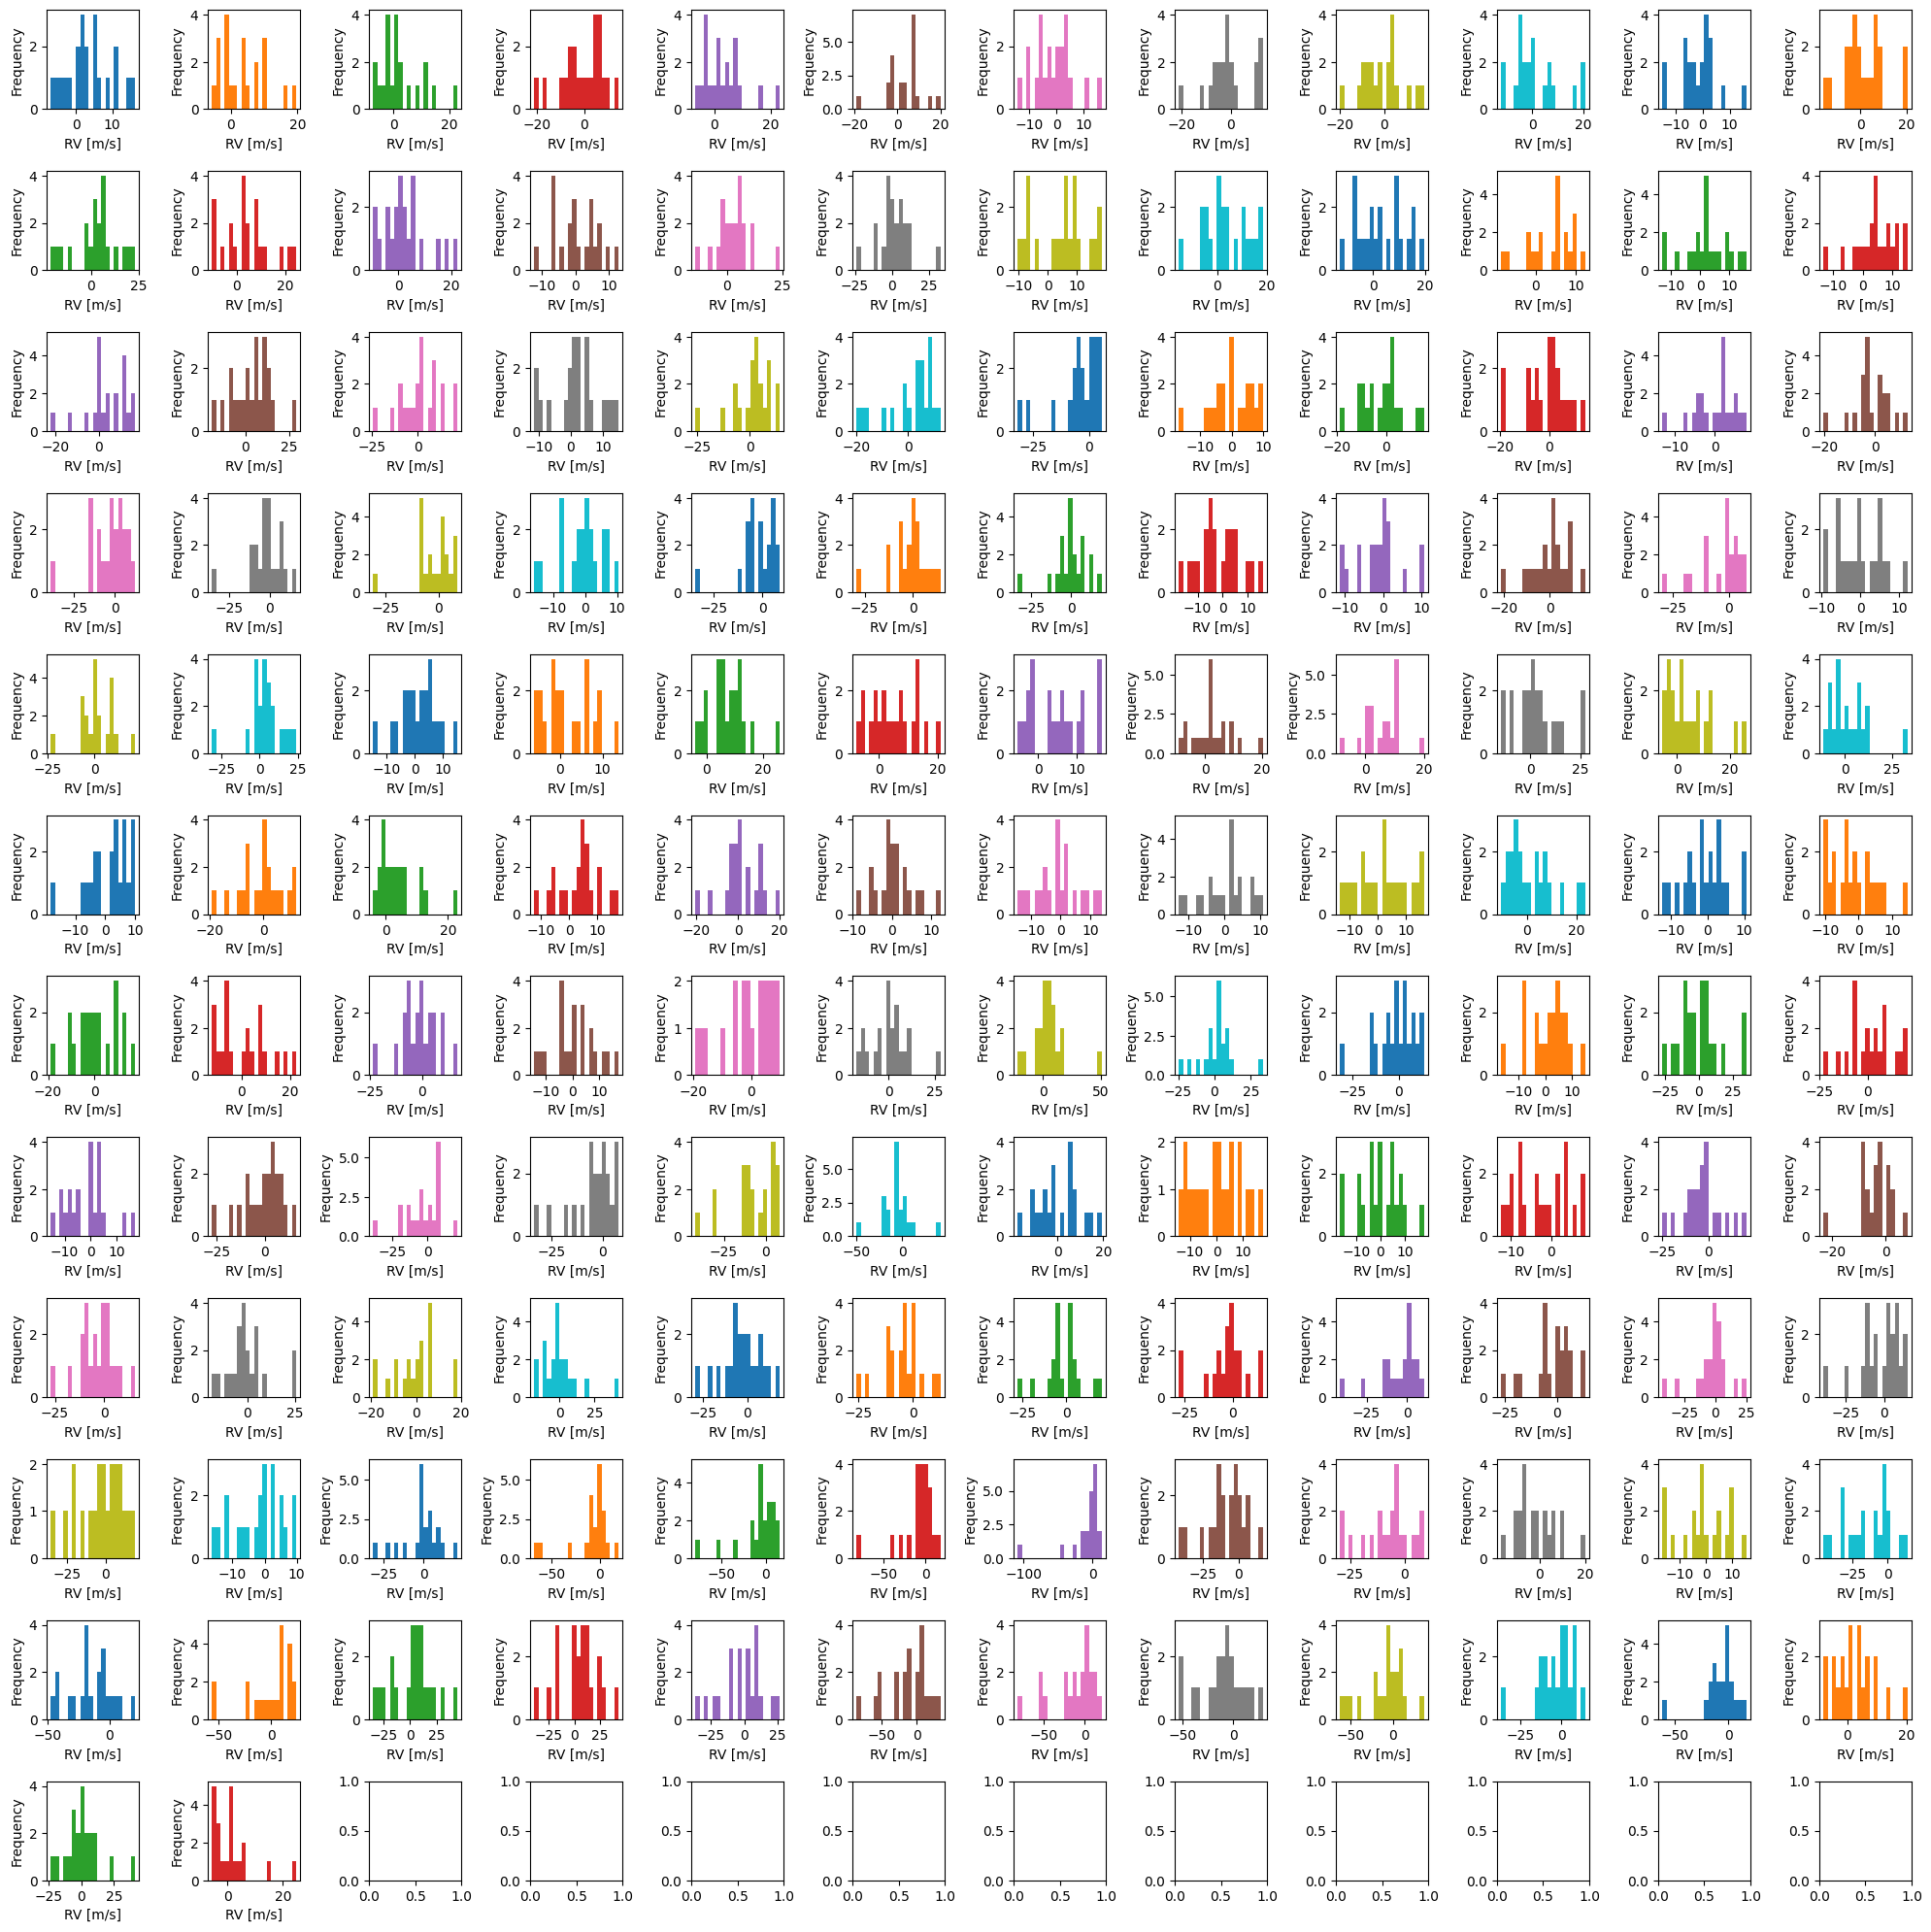

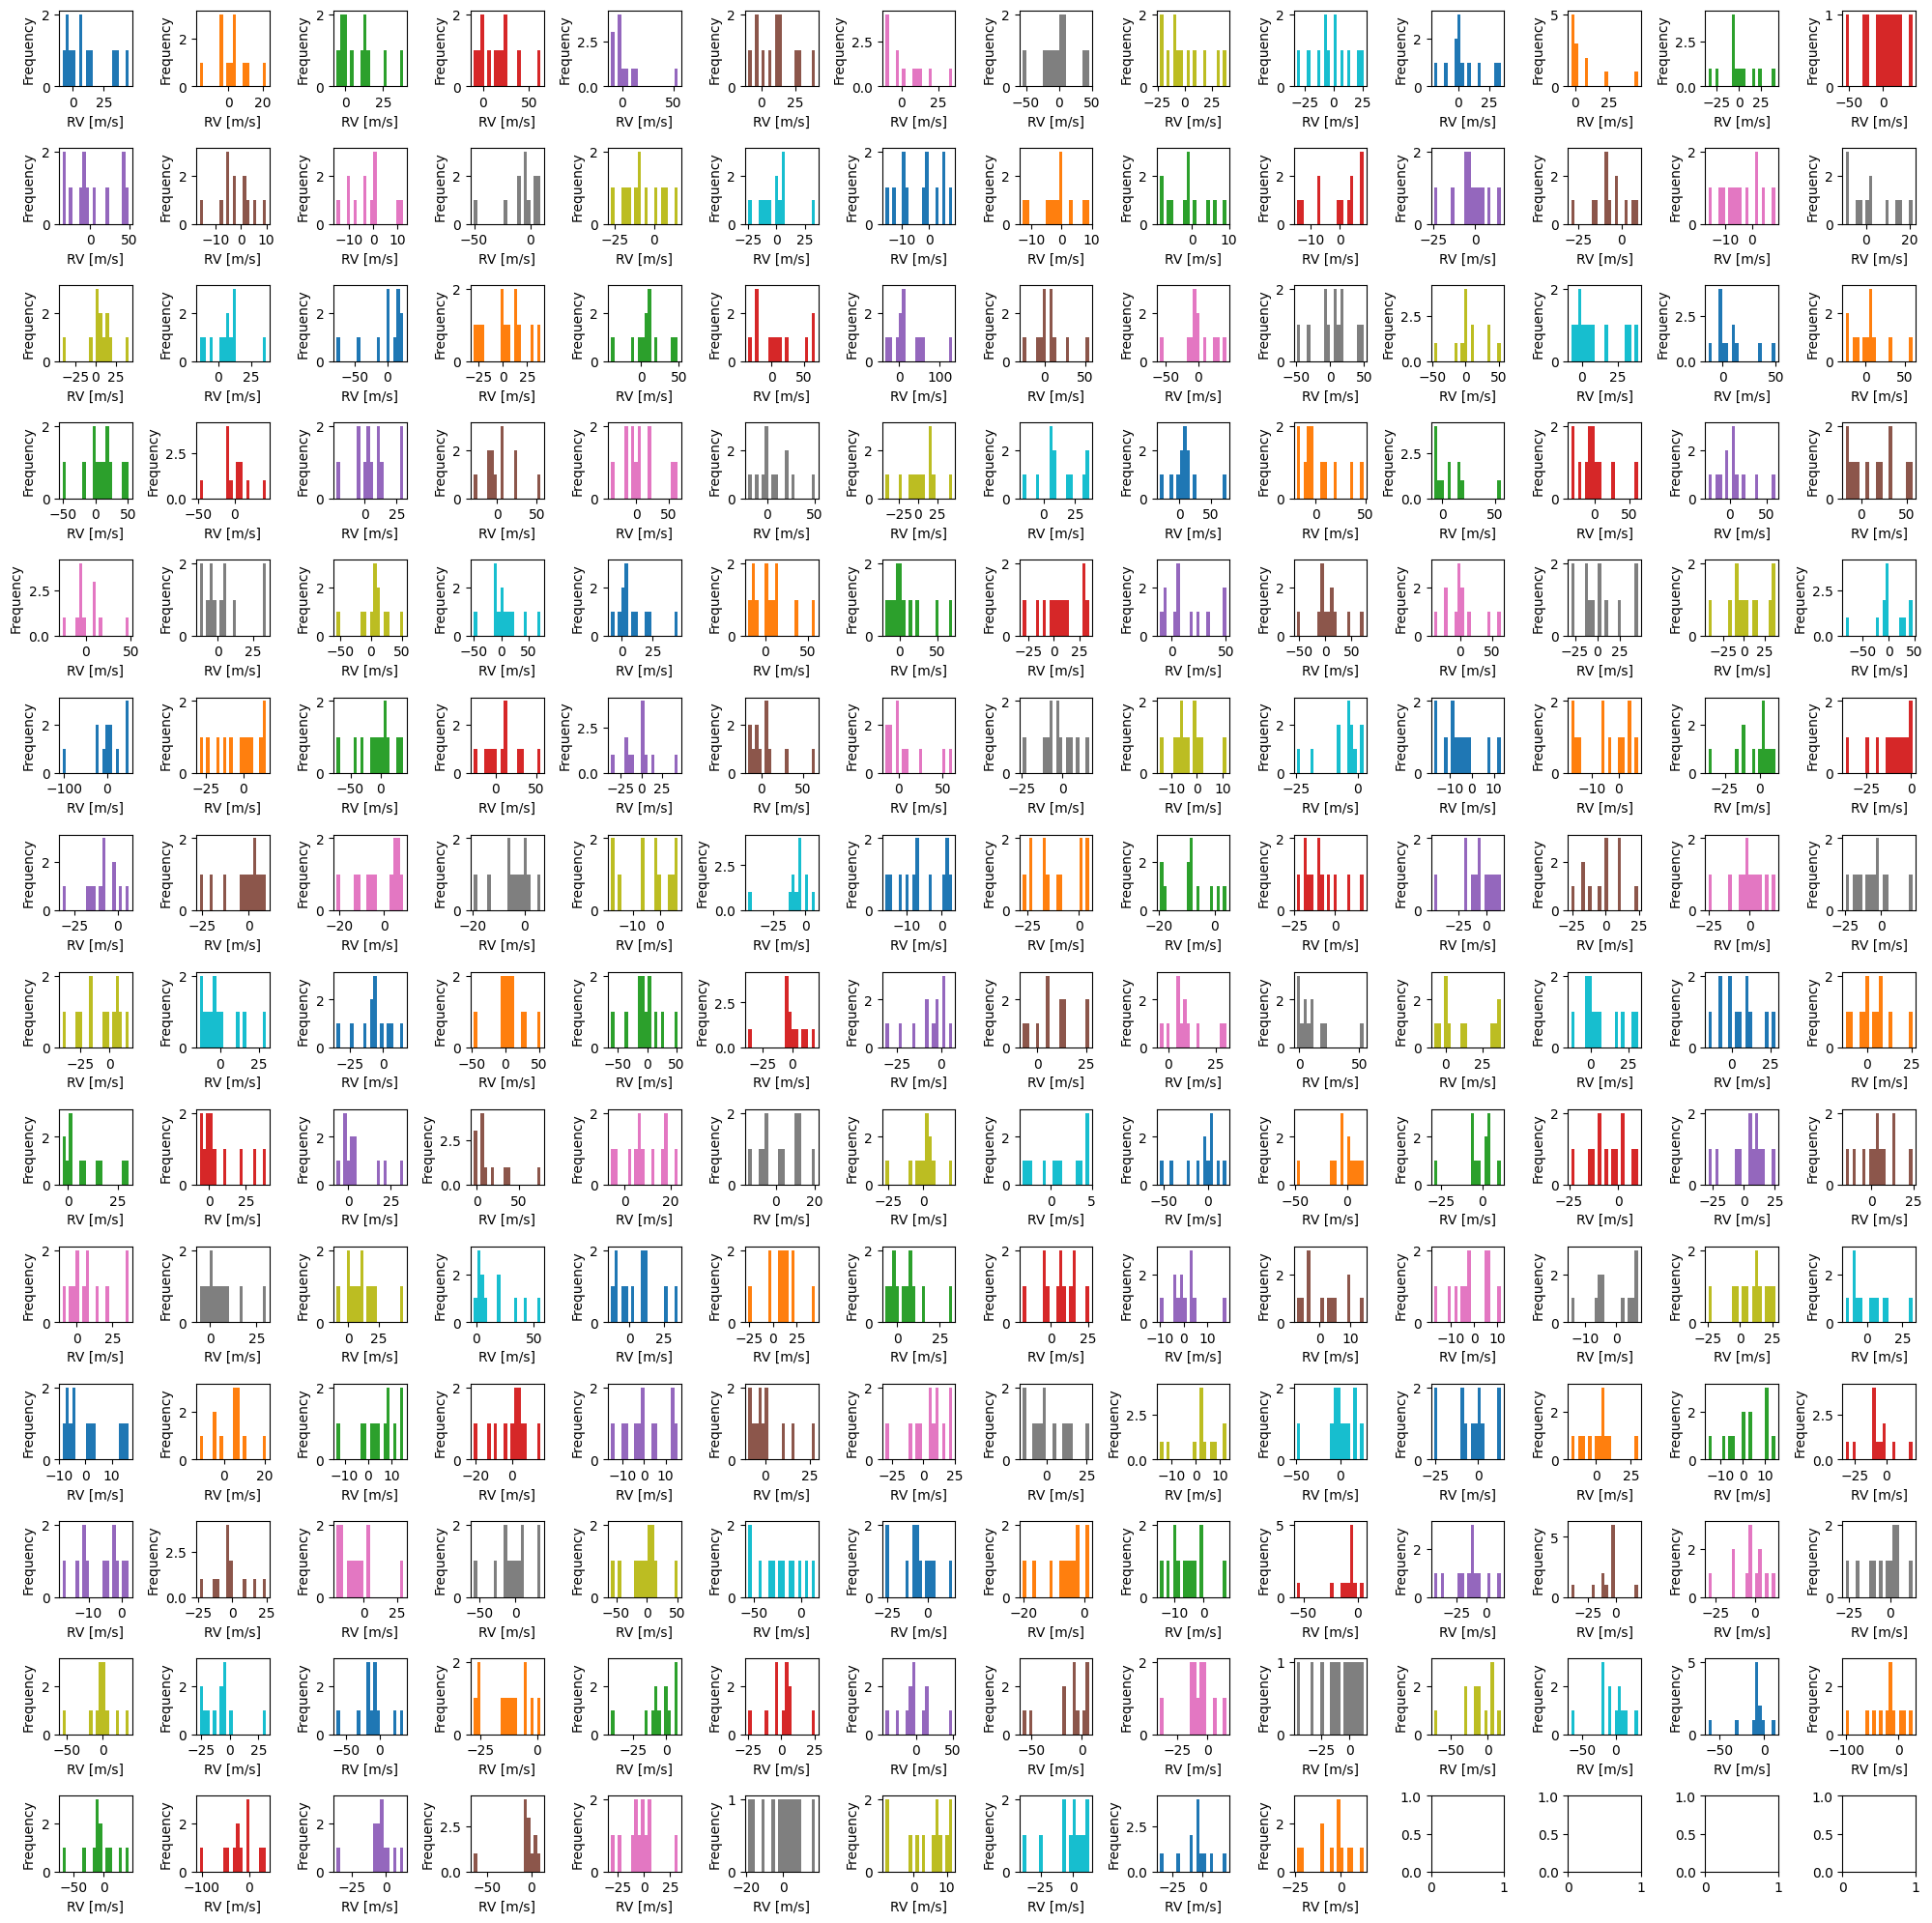

In [74]:
# Dictionnary to store the RVs of each time 
rv_waves = {}

for instrument in instruments:
    rv_waves[instrument] = [[y_rv[instrument][f'vrad_{wave}nm'][t] for wave in good_waves[instrument]] for t in range(len(tbl[instrument]['rjd']))]
    
    # Create a new figure with subplots
    sqrt_N_display_time = int(np.sqrt(len(tbl[instrument]['rjd'])))+1
    fig, axs = plt.subplots(sqrt_N_display_time, sqrt_N_display_time, figsize=(20, 20))

    # Plot histograms for each wavelength
    for i, time in enumerate(tbl[instrument]['rjd']):
        row = i // sqrt_N_display_time
        col = i %  sqrt_N_display_time
        
            
        axs[row, col].hist(rv_waves[instrument][i], color = f'C{i}', bins=20)
        axs[row, col].set_xlabel('RV [m/s]')
        axs[row, col].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()